<p style="font-family: 'Courier New', Courier, monospace; font-size: 50px; font-weight: bold; color: blue;  text-align: center;">
  LoRaWAN Path Loss Measurements in an Indoor Setting: DATA SORTING
</p>

In [2]:
# Libraries/Packages Used:

import pandas as pd                        # For data manipulation and analysis.
import matplotlib.pyplot as plt            # For creating static visualizations.

%matplotlib inline

In [3]:
# Read data from a local CSV file
new_df = pd.read_csv('../all_data_files/unsorted_combined_measurements_data.csv', low_memory=False)

# Print the info about the combined DataFrame
print("\nInfo of Combined DataFrame:\n")
new_df.info()


Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283035 entries, 0 to 1283034
Data columns (total 81 columns):
 #   Column                                                   Non-Null Count    Dtype  
---  ------                                                   --------------    -----  
 0   time                                                     1283035 non-null  object 
 1   correlation_ids_0                                        1283035 non-null  object 
 2   device_id                                                1283035 non-null  object 
 3   end_device_ids_application_ids_application_id            1283035 non-null  object 
 4   end_device_ids_dev_addr                                  1283035 non-null  object 
 5   end_device_ids_dev_eui                                   1283035 non-null  object 
 6   end_device_ids_device_id                                 1283035 non-null  object 
 7   end_device_ids_join_eui                                  128

Found 2 rows with invalid datetime format:


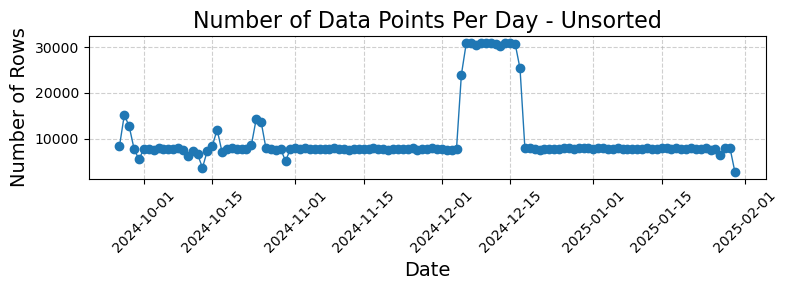

In [4]:
# Ensure 'time' column is in string format
new_df['time'] = new_df['time'].astype(str)

# Convert 'time' to datetime, handling time zones and errors
new_df['time'] = pd.to_datetime(new_df['time'], errors='coerce', utc=True)

# Check for rows where parsing failed
invalid_times = new_df[new_df['time'].isna()]
if not invalid_times.empty:
    print(f"Found {len(invalid_times)} rows with invalid datetime format:")

# Drop rows with invalid 'time' values
new_df = new_df.dropna(subset=['time'])

# Extract the date part from the 'time' column
new_df['date'] = new_df['time'].dt.date

# Count the number of rows per day
rows_per_day = new_df.groupby('date').size()

# Plot the number of rows per day as a line plot
plt.figure(figsize=(8, 3))
rows_per_day.plot(kind='line', marker='o', linestyle='-', linewidth=1)
plt.title('Number of Data Points Per Day - Unsorted', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Rows', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Initialize an empty set to collect unique gateway IDs
unique_gateways = set()

# Loop over the metadata indices (adjust the range if you have more metadata columns)
for i in range(3):  # this covers metadata_0, metadata_1, metadata_2
    col_name = f'uplink_message_rx_metadata_{i}_gateway_ids_gateway_id'
    if col_name in new_df.columns:
        # Add unique values from the column to the set, excluding NaN
        unique_gateways.update(new_df[col_name].dropna().unique())

# Number of unique gateways
num_unique_gateways = len(unique_gateways)
print("Number of unique gateways:", num_unique_gateways)

# Optionally, list them
print("Unique gateway IDs:", unique_gateways)

Number of unique gateways: 4
Unique gateway IDs: {'eui-a84041ffff22def8', 'kerlink001', 'eui-a84041ffff22dea4', 'kerlink-istation'}


In [6]:
# Initialize an empty set to collect unique gateway IDs
unique_gateways = set()

# Loop over the metadata indices to find all unique gateway IDs
for i in range(3):  # This covers metadata_0, metadata_1, metadata_2
    col_name = f'uplink_message_rx_metadata_{i}_gateway_ids_gateway_id'
    if col_name in new_df.columns:
        # Add unique values from the column to the set, excluding NaN
        unique_gateways.update(new_df[col_name].dropna().unique())

# Dictionary to store the sum of rows for each gateway
gateway_row_counts = {}

# Count rows for each gateway across all metadata columns
for gw in unique_gateways:
    # Create a boolean mask for the gateway in any metadata column
    mask = (
        (new_df['uplink_message_rx_metadata_0_gateway_ids_gateway_id'] == gw) |
        (new_df['uplink_message_rx_metadata_1_gateway_ids_gateway_id'] == gw) |
        (new_df['uplink_message_rx_metadata_2_gateway_ids_gateway_id'] == gw)
    )
    # Count rows where the mask is True
    gateway_row_counts[gw] = mask.sum()

# Print the results
print("Rows per gateway:")
for gw, count in gateway_row_counts.items():
    print(f"{gw}: {count}")

Rows per gateway:
eui-a84041ffff22def8: 877500
kerlink001: 1267618
eui-a84041ffff22dea4: 151056
kerlink-istation: 1


In [7]:
# Define the target gateway ID
target_gateway = "kerlink001"

# Create a boolean mask for rows where the gateway ID matches in any metadata column
mask = (
    (new_df['uplink_message_rx_metadata_0_gateway_ids_gateway_id'] == target_gateway) |
    (new_df['uplink_message_rx_metadata_1_gateway_ids_gateway_id'] == target_gateway) |
    (new_df['uplink_message_rx_metadata_2_gateway_ids_gateway_id'] == target_gateway)
)

# Filter the DataFrame to retain only rows with the target gateway
new_df = new_df[mask]

# Reset the index if desired (optional)
new_df.reset_index(drop=True, inplace=True)

# Display the result
new_df.shape

(1267618, 82)

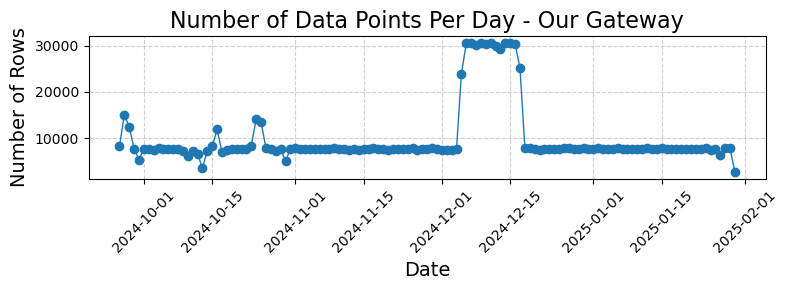

In [8]:
# Ensure 'time' column is in string format
new_df['time'] = new_df['time'].astype(str)

# Convert 'time' to datetime, handling time zones and errors
new_df['time'] = pd.to_datetime(new_df['time'], errors='coerce', utc=True)

# Check for rows where parsing failed
invalid_times = new_df[new_df['time'].isna()]
if not invalid_times.empty:
    print(f"Found {len(invalid_times)} rows with invalid datetime format:")

# Drop rows with invalid 'time' values
new_df = new_df.dropna(subset=['time'])

# Extract the date part from the 'time' column
new_df['date'] = new_df['time'].dt.date

# Count the number of rows per day
rows_per_day = new_df.groupby('date').size()

# Plot the number of rows per day as a line plot
plt.figure(figsize=(8, 3))
rows_per_day.plot(kind='line', marker='o', linestyle='-', linewidth=1)
plt.title('Number of Data Points Per Day - Our Gateway', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Rows', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Original shape: (1267618, 84)
Deduplicated shape: (947039, 82)


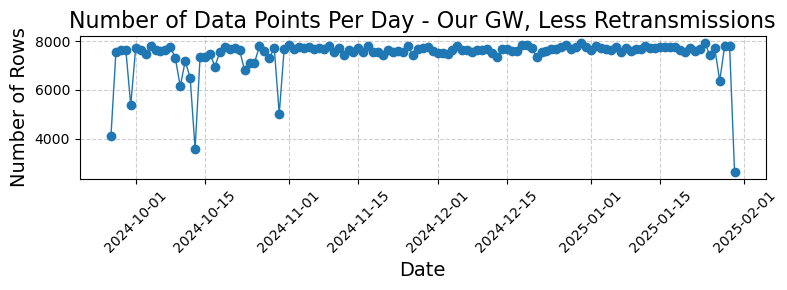

In [9]:
# Ensure 'time' is datetime and sort the DataFrame
new_df["time"] = pd.to_datetime(new_df["time"], utc=True, errors="coerce")
new_df = new_df.sort_values(["end_device_ids_device_id", "time"]).copy()

# Compute group-wise differences in a vectorized way
# Calculate time difference and frame counter difference within each device group
new_df["dt"] = new_df.groupby("end_device_ids_device_id")["time"].diff().dt.total_seconds()
new_df["df_cnt"] = new_df.groupby("end_device_ids_device_id")["uplink_message_f_cnt"].diff()

# Create a boolean mask for non-duplicate rows
# A row is considered a duplicate if:
#    - The difference in frame count (df_cnt) is 0
#    - The time difference (dt) is less than the threshold (2.0 seconds)
non_duplicate_mask = ~((new_df["df_cnt"] == 0) & (new_df["dt"] < 2.0))

# Apply the mask to filter the DataFrame
df_dedup = new_df[non_duplicate_mask].copy()

# Clean up intermediate columns if not needed
df_dedup.drop(columns=["dt", "df_cnt"], inplace=True, errors="ignore")
df_dedup.reset_index(drop=True, inplace=True)

print("Original shape:", new_df.shape)
print("Deduplicated shape:", df_dedup.shape)

# Plot daily counts
df_dedup["date"] = df_dedup["time"].dt.date
daily_counts = df_dedup.groupby("date").size()

plt.figure(figsize=(8, 3))
daily_counts.plot(
    kind='line',
    marker='o',
    linestyle='-',
    linewidth=1
)
plt.title('Number of Data Points Per Day - Our GW, Less Retransmissions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Rows', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Save the cleaned and aggregated and SORTED data to a CSV file 
df_dedup.to_csv('../all_data_files/combined_measurements_data.csv', index=False)

print("Data sorting and removal of duplicates completed. A CSV file has been saved!")

print("\n DATA INFORMATION. \n")
df_dedup.info()

Data sorting and removal of duplicates completed. A CSV file has been saved!

 DATA INFORMATION. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947039 entries, 0 to 947038
Data columns (total 82 columns):
 #   Column                                                   Non-Null Count   Dtype              
---  ------                                                   --------------   -----              
 0   time                                                     947039 non-null  datetime64[ns, UTC]
 1   correlation_ids_0                                        947039 non-null  object             
 2   device_id                                                947039 non-null  object             
 3   end_device_ids_application_ids_application_id            947039 non-null  object             
 4   end_device_ids_dev_addr                                  947039 non-null  object             
 5   end_device_ids_dev_eui                                   947039 non-null  object            